## Reachability for linear hybrid systems

First we transform the initial-value problem

$$
x'(t) = Ax(t) + Bu(t) + c,\qquad x(0) \in \mathcal{X}_0, u(t) \in \mathcal{\tilde{U}}, x(t) \in \mathcal{I}
$$
into the **normalized** form
$$
\boxed{x'(t) = Ax(t) + u(t),\qquad x(0) \in \mathcal{X}_0, u(t) \in \mathcal{U}, x(t) \in \mathcal{I}}
$$

here:

- $A \in \mathbb{R}^{n\times n}$ and $B \in \mathbb{R}^{n\times m}$ are the state and inputs matrices respectively
- $\mathcal{X}_0 \subseteq \mathbb{R}^n$ is the *set of initial states*
- $\mathcal{I} \subseteq \mathbb{R}^n$: is the *invariant*
- $\mathcal{U} \subseteq \mathbb{R}^m$: is the *set of uncertain initial states*

Next we apply a suitable *discretization* method, such that it returns $\Omega_0$ which encloses the trajectories for the time interval $[0, \delta]$, namely

$$
\mathcal{R}^e([0, \delta]) \subseteq \Omega_0
$$
where $\mathcal{R}^e([0, \delta])$ denotes the *exact* reachable set in the time interval $[0, \delta]$.

Different **approximation models** (= discretization methods) are implemented:

- First order approximation [1]

- **Forward** interpolation method see eg. SpaceEx paper. [2]

- Backward interpolation method see eg. SpaceEx paper. [2]

- Correction Hull method for zonotopes, see eg. M. Althoff's thesis Chapters 2-3. [3]

- Correction Hull method for Interval Matrices $A$, see [3, 4]

- No bloating interpolation method as in HyLAA ie. for "discrete-time" reachability.

---

- [1] Le Guernic, C., & Girard, A., 2010, *Reachability analysis of linear systems
using support functions. Nonlinear Analysis: Hybrid Systems, 4(2), 250-262.*

- [2] Frehse, Goran, et al. "SpaceEx: Scalable verification of hybrid systems."
International Conference on Computer Aided Verification. Springer, Berlin,
Heidelberg, 2011.

- [3] Althoff, M. (2010). Reachability analysis and its application to the safety assessment of autonomous cars (Doctoral dissertation, Technische Universität München). pdf, M. Althoff's PhD thesis. Tags: zonotope, zonotope order reduction, interval matrix, matrix zonotope.

- [4] M. Althoff, O. Stursberg, M. Buss. Reachability Analysis of Linear Systems
with Uncertain Parameters and Inputs. CDC 2007.

---

After discretization with step-size $\delta > 0$ we have to solve the discrete recurrence:

$$
X_{k+1} = (\Phi X_k \oplus U)\cap I,\qquad k = 0, \ldots, N
$$

where $\Phi = e^{A\delta}$ is the matrix exponential of the state matrix (state *transition matrix*), and $X_0 := \Omega_0$ is the set after discretization.

---

## GLGM06 : pseudocode

The main point is that by unrolling the set-based recurrence we get a wrapping-free method: errors are not propagated. This is called the non-recursive implementation. Works by updating two sequences, one sequence for the propagation of the initial states and another sequence for the propagation of the input set.  Idea:

- $X_1 = \Phi X_0 \oplus W$ where $W := U$
- $X_2 = \Phi X_1 \oplus U = \Phi(\Phi X_0 \oplus U) \oplus U = \Phi^2 X_0 \oplus W$, where $W := \Phi U \oplus U$
- $X_3 = \Phi^3 X_0 \oplus W$ where $W := \Phi^2 U \oplus \Phi U \oplus U$
- and so on.

For efficiency reasons we intermediately reduce the order of the $X_k$:

- `W := U` :: Zonotope

- `X₁ = Φ * X₀ ⊕ W`:: Zonotope

- `X₁ = reduce_order(X₁, max_order)`:: Zonotope

- `W = Φ * U ⊕ U` :: Zonotope
- `W = reduce_order(W, max_order)` :: Zonotope

- `X₂ = Φ² * X₀ ⊕ W`:: Zonotope
- `X₂ = reduce_order(X₂, max_order)`:: Zonotope

- `W = Φ² * U ⊕ Φ * U ⊕ U` :: Zonotope
- `W = reduce_order(W, max_order)` :: Zonotope

and so on.

On the other hand we can use this method to lazily verify properties of the flowpipe.

If there is a non-universal invariant, we make a disjointness check in the loop and finish the computation if the reach-set is disjoint with the invariant.

## GLGM06 : implementation

```julia
# with invariant
function reach_inhomog_GLGM06!(F::Vector{ReachSet{N, Zonotope{N, VN, MN}}},
                               Ω0::Zonotope{N, VN, MN},
                               Φ::AbstractMatrix,
                               NSTEPS::Integer,
                               δ::Float64,
                               max_order::Integer,
                               X::LazySet,
                               U::LazySet,
                               reduction_method::AbstractReductionMethod,
                               time_shift::N,
                               disjointness_method::AbstractDisjointnessMethod) where {N, VN, MN}

    # initial reach set
    Δt = (zero(N) .. δ) + time_shift
    @inbounds F[1] = ReachSet(Ω0, Δt)

    Wk₊ = U
    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)

    k = 2
    @inbounds while k <= NSTEPS
        Rₖ = minkowski_sum(_linear_map(Φ_power_k, Ω0), Wk₊)
        Rₖ = _reduce_order(Rₖ, max_order, reduction_method)
        _is_intersection_empty(X, Rₖ, disjointness_method) && break
        Δt += δ
        F[k] = ReachSet(Rₖ, Δt)

        Wk₊ = minkowski_sum(Wk₊, _linear_map(Φ_power_k, U))
        Wk₊ = _reduce_order(Wk₊, max_order, reduction_method)

        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copyto!(Φ_power_k, Φ_power_k_cache)
        k += 1
    end
    if k < NSTEPS + 1
        resize!(F, k-1)
    end
    return F
end
```

---

## Hybrid automata: notation

[5] Reachability analysis of linear hybrid systems via block decomposition. Sergiy Bogomolov, Marcelo Forets, Goran Frehse, Kostiantyn Potomkin, Christian Schilling. Get pdf from arXiv: 1905.02458. Accepted in Embedded Systems Week 2020.

[6] Frehse, Goran, and Rajarshi Ray. Flowpipe-Guard Intersection for Reachability Computations with Support Functions. ADHS. 2012.

<img src="linear_hybrid_systems_1.png" alt="Drawing" style="width: 600px;"/>

<img src="linear_hybrid_systems_2.png" alt="Drawing" style="width: 600px;"/>

<img src="linear_hybrid_systems_3.png" alt="Drawing" style="width: 600px;"/>

<img src="linear_hybrid_systems_4.png" alt="Drawing" style="width: 600px;"/>

## Example: thermostat

<img src="thermostat.png" alt="Drawing" style="width: 600px;"/>

In [30]:
using Revise, ReachabilityAnalysis, ModelingToolkit, Plots

In [31]:
function thermostat(; K=1.0, h=30.0)
    @variables x
    
    # automaton structure
    automaton = LightAutomaton(2)
    
    # modes
    A = hcat(-K); b = [K*h]
    Lon = @system(x' = Ax + b, x ∈ HalfSpace(x ≤ 23)) # "on" mode
    Loff = @system(x' = Ax, x ∈ HalfSpace(x ≥ 17)) # "off" mode
    modes = [Lon, Loff]

    # transitions
    add_transition!(automaton, 1, 2, 1) # transition from on to off
    t1 = @map(x -> x, dim=1, x ∈ HalfSpace(x ≥ 22))
    add_transition!(automaton, 2, 1, 2) # transition from off to on
    t2 = @map(x -> x, dim=1, x ∈ HalfSpace(x ≤ 18))
    resetmaps = [t1, t2]

    HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])
end

thermostat (generic function with 1 method)

In [32]:
H = thermostat()
prob = @ivp(H, x(0) ∈ [(1, Interval(19, 20))]) # initial condition in mode 1

InitialValueProblem{HybridSystem{LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}},AbstractContinuousSystem,ConstrainedIdentityMap{HalfSpace{Float64,Array{Float64,1}}},AutonomousSwitching,Array{AbstractContinuousSystem,1},Array{ConstrainedIdentityMap{HalfSpace{Float64,Array{Float64,1}}},1},Array{AutonomousSwitching,1}},Array{Tuple{Int64,Interval{Float64,IntervalArithmetic.Interval{Float64}}},1}}(Hybrid System with automaton LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({2, 2} directed simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Dict{Int64,Int64}}(Edge 1 => 2 => Dict(1 => 1),Edge 2 => 1 => Dict(2 => 2)), 2, 2), Tuple{Int64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}[(1, Interval{Float64,IntervalArithmetic.Interval{Float64}}([19, 20]))])

In [33]:
sol = solve(prob, T=10.0, alg=INT(δ=0.005));

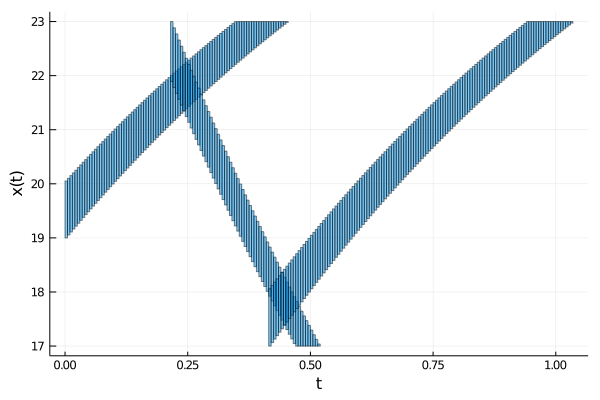

In [34]:
plot(sol, vars=(0, 1), xlab="t", ylab="x(t)")

## Pseudo-code hybrid solve

The "standard" algorithm is shown below, taken from [1]. This is implemented in `ReachabilityAnalysis.jl` as `solve` dispatching on initial-value problems for hybrid systems.

- [1] Le Guernic, C., & Girard, A., 2010, *Reachability analysis of linear systems
using support functions. Nonlinear Analysis: Hybrid Systems, 4(2), 250-262.*

![hybrid_solve.png](hybrid_solve.png)